# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [1]:
#Name
ModelName = 'titanic_propensity_survive'

#Setting the model target variable name
VarTarget = 'Survived'
VarId = 'PassengerId'
VarDate = 'ReferenceDate' 

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'Ticket_str'
,'NameTitle']

#float
NUM = ['Fare'
,'SibSp'
,'Parch'
,'Age_Mean'
,'Ticket_int']
selected_features = CAT + NUM

# 2. Import Libraries

In [2]:
# !pip -q install -r requirements.txt

In [3]:
try:
    import sys
    sys.path.append('/anaconda/envs/azureml_py38/lib/python3.8/site-packages')    
except:
    pass

In [4]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [5]:
dataprep_df_full = pd.read_csv('./titanic/dataprep_df.csv')

In [6]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [7]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(int)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

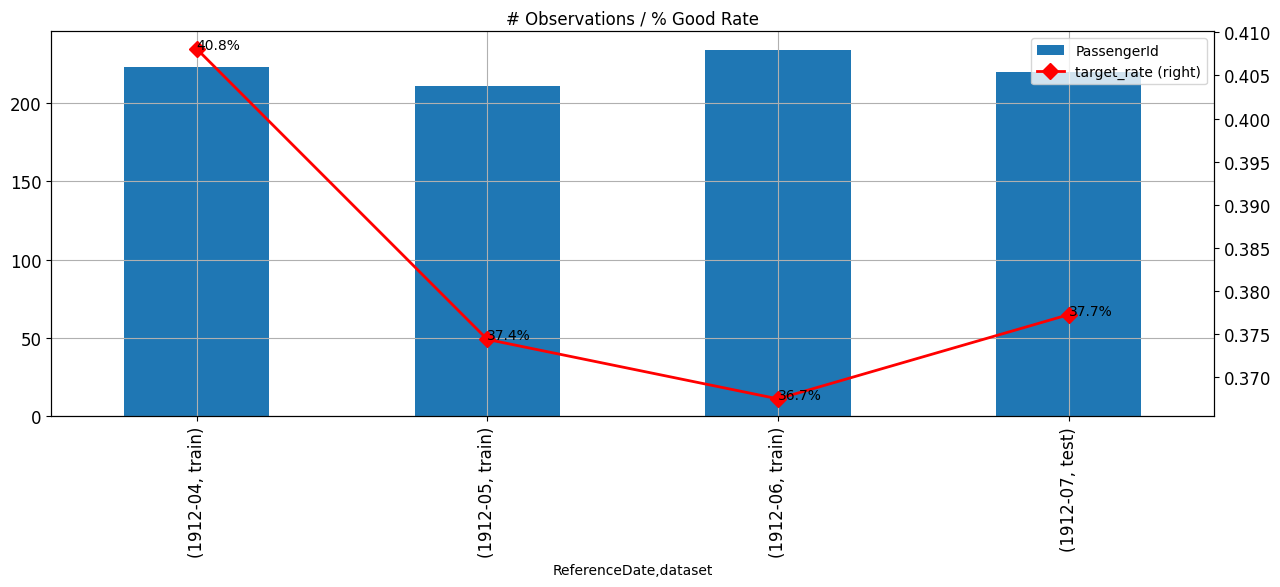

In [8]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'dataset']].groupby(by=[VarDate, 'dataset']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]

dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [9]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [10]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [11]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O and Importing data into the H2O context

In [12]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpghzfrgtr
  JVM stdout: /tmp/tmpghzfrgtr/h2o_azureuser_started_from_python.out
  JVM stderr: /tmp/tmpghzfrgtr/h2o_azureuser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,25 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 23 days !!!
H2O_cluster_name:,H2O_from_python_azureuser_j7lfmd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,451.0 Mb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


In [13]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 604
Validation: 64


In [14]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 220


## 4.2.2 Train the H2O Champion algorithm with new data

In [15]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='h2o_champion_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o_champion = H2OGradientBoostingEstimator(model_id='%s%s_%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                    nfolds= 5,
                                    keep_cross_validation_models= False,
                                    keep_cross_validation_predictions= True,
                                    keep_cross_validation_fold_assignment= False,
                                    score_each_iteration= False,
                                    score_tree_interval= 5,
                                    fold_assignment='Modulo',
                                    fold_column= None,
                                    ignore_const_cols= True,
                                    offset_column= None,
                                    weights_column= None,
                                    balance_classes= False,
                                    class_sampling_factors= None,
                                    max_after_balance_size= 5.0,
                                    max_confusion_matrix_size= 20,
                                    ntrees= 120,
                                    max_depth= 4,
                                    min_rows= 100.0,
                                    nbins= 20,
                                    nbins_top_level= 1024,
                                    nbins_cats= 1024,
                                    r2_stopping= 1.7976931348623157e+308,
                                    stopping_rounds= 2,
                                    stopping_metric='AUCPR',
                                    stopping_tolerance= 0.002303474948339114,
                                    max_runtime_secs= 31688.0,
                                    seed= 101,
                                    build_tree_one_node= False,
                                    learn_rate= 0.1,
                                    learn_rate_annealing= 1.0,
                                    distribution='bernoulli',
                                    quantile_alpha= 0.5,
                                    tweedie_power= 1.5,
                                    huber_alpha= 0.9,
                                    checkpoint= None,
                                    sample_rate= 0.9,
                                    sample_rate_per_class= None,
                                    col_sample_rate= 0.4,
                                    col_sample_rate_change_per_level= 1.0,
                                    col_sample_rate_per_tree= 0.7,
                                    min_split_improvement= 1e-05,
                                    histogram_type='UniformAdaptive',
                                    max_abs_leafnode_pred= 1.7976931348623157e+308,
                                    pred_noise_bandwidth= 0.0,
                                    categorical_encoding='Enum',
                                    calibrate_model= False,
                                    calibration_frame= None,
                                    custom_metric_func= None,
                                    custom_distribution_func= None,
                                    export_checkpoints_dir= None,
                                    monotone_constraints= None,
                                    check_constant_response= True,
                                    gainslift_bins= -1,
                                    auc_type='AUTO',
                                    interaction_constraints= None)

# The use of a validation_frame is recommended with using early stopping
h2o_champion.train(x=selected_features, y=VarTarget, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(h2o_champion)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:18.082416

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  h2o_champion_titanic_propensity_survive_v1_20221201_193127


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,43.0,43.0,4403.0,1.0,4.0,2.418605,2.0,5.0,3.465116




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1309978483939465
RMSE: 0.36193624907426236
LogLoss: 0.4257172906325796
Mean Per-Class Error: 0.17624978377443348
AUC: 0.8897364931096119
AUCPR: 0.8753090186176796
Gini: 0.7794729862192238

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4789548613563892: 


,,0,1,Error,Rate
0,0,330.0,39.0,0.1057,(39.0/369.0)
1,1,58.0,177.0,0.2468,(58.0/235.0)
2,Total,388.0,216.0,0.1606,(97.0/604.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.478955,0.784922,165.0
1,max f2,0.228748,0.835258,277.0
2,max f0point5,0.588489,0.850059,125.0
3,max accuracy,0.497639,0.839404,156.0
4,max precision,0.875218,1.000000,0.0
5,max recall,0.108632,1.000000,381.0
6,max specificity,0.875218,1.000000,0.0
7,max absolute_mcc,0.559938,0.659879,130.0
8,max min_per_class_accuracy,0.430933,0.821138,198.0
9,max mean_per_class_accuracy,0.478955,0.823750,165.0



Gains/Lift Table: Avg response rate: 38.91 %, avg score: 38.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011589,0.863564,2.570213,2.570213,1.000000,0.869138,1.000000,0.869138,0.029787,0.029787,157.021277,157.021277,0.029787
1,2,0.021523,0.854825,2.570213,2.570213,1.000000,0.857939,1.000000,0.863969,0.025532,0.055319,157.021277,157.021277,0.055319
2,3,0.034768,0.848863,2.570213,2.570213,1.000000,0.850852,1.000000,0.858972,0.034043,0.089362,157.021277,157.021277,0.089362
3,4,0.043046,0.843917,2.570213,2.570213,1.000000,0.844712,1.000000,0.856230,0.021277,0.110638,157.021277,157.021277,0.110638
4,5,0.051325,0.835234,2.570213,2.570213,1.000000,0.838358,1.000000,0.853347,0.021277,0.131915,157.021277,157.021277,0.131915
5,6,0.100993,0.797408,2.484539,2.528078,0.966667,0.816492,0.983607,0.835222,0.123404,0.255319,148.453901,152.807813,0.252609
6,7,0.150662,0.721448,2.398865,2.485480,0.933333,0.761498,0.967033,0.810917,0.119149,0.374468,139.886525,148.548048,0.366338
7,8,0.200331,0.667141,2.484539,2.485247,0.966667,0.698735,0.966942,0.783103,0.123404,0.497872,148.453901,148.524705,0.487032
8,9,0.299669,0.529695,1.756312,2.243611,0.683333,0.583629,0.872928,0.716979,0.174468,0.672340,75.631206,124.361114,0.610010
9,10,0.402318,0.448202,1.077831,1.946169,0.419355,0.480608,0.757202,0.656671,0.110638,0.782979,7.783116,94.616934,0.623087




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1442662175121267
RMSE: 0.3798239296201948
LogLoss: 0.4603000128433505
Mean Per-Class Error: 0.18992248062015504
AUC: 0.8133997785160575
AUCPR: 0.7557289804846716
Gini: 0.626799557032115

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5307451462321384: 


,,0,1,Error,Rate
0,0,41.0,2.0,0.0465,(2.0/43.0)
1,1,7.0,14.0,0.3333,(7.0/21.0)
2,Total,48.0,16.0,0.1406,(9.0/64.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.530745,0.756757,15.0
1,max f2,0.197242,0.772358,37.0
2,max f0point5,0.541939,0.844156,13.0
3,max accuracy,0.541939,0.859375,13.0
4,max precision,0.866850,1.000000,0.0
5,max recall,0.115860,1.000000,49.0
6,max specificity,0.866850,1.000000,0.0
7,max absolute_mcc,0.541939,0.676689,13.0
8,max min_per_class_accuracy,0.299160,0.720930,27.0
9,max mean_per_class_accuracy,0.530745,0.810078,15.0



Gains/Lift Table: Avg response rate: 32.81 %, avg score: 35.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015625,0.860491,3.047619,3.047619,1.000000,0.866850,1.000000,0.866850,0.047619,0.047619,204.761905,204.761905,0.047619
1,2,0.031250,0.846821,3.047619,3.047619,1.000000,0.856756,1.000000,0.861803,0.047619,0.095238,204.761905,204.761905,0.095238
2,3,0.031250,0.822747,0.000000,3.047619,0.000000,0.000000,1.000000,0.861803,0.000000,0.095238,-100.000000,204.761905,0.095238
3,4,0.046875,0.818487,3.047619,3.047619,1.000000,0.818544,1.000000,0.847383,0.047619,0.142857,204.761905,204.761905,0.142857
4,5,0.062500,0.818435,0.000000,2.285714,0.000000,0.818436,0.750000,0.840146,0.000000,0.142857,-100.000000,128.571429,0.119601
5,6,0.109375,0.788240,3.047619,2.612245,1.000000,0.809018,0.857143,0.826806,0.142857,0.285714,204.761905,161.224490,0.262458
6,7,0.156250,0.709444,3.047619,2.742857,1.000000,0.743494,0.900000,0.801812,0.142857,0.428571,204.761905,174.285714,0.405316
7,8,0.203125,0.590641,3.047619,2.813187,1.000000,0.683652,0.923077,0.774544,0.142857,0.571429,204.761905,181.318681,0.548173
8,9,0.296875,0.479501,1.015873,2.245614,0.333333,0.516875,0.736842,0.693175,0.095238,0.666667,1.587302,124.561404,0.550388
9,10,0.406250,0.308258,0.000000,1.641026,0.000000,0.387948,0.538462,0.610999,0.000000,0.666667,-100.000000,64.102564,0.387597




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.14888126416605385
RMSE: 0.3858513498305453
LogLoss: 0.4719857718774101
Mean Per-Class Error: 0.2026235368736666
AUC: 0.8613215706625151
AUCPR: 0.8266361093077604
Gini: 0.7226431413250303

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37427794130310027: 


,,0,1,Error,Rate
0,0,265.0,104.0,0.2818,(104.0/369.0)
1,1,29.0,206.0,0.1234,(29.0/235.0)
2,Total,294.0,310.0,0.2202,(133.0/604.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.374278,0.755963,231.0
1,max f2,0.374278,0.824000,231.0
2,max f0point5,0.549608,0.811429,127.0
3,max accuracy,0.538931,0.817881,132.0
4,max precision,0.898766,1.000000,0.0
5,max recall,0.066362,1.000000,397.0
6,max specificity,0.898766,1.000000,0.0
7,max absolute_mcc,0.538931,0.615190,132.0
8,max min_per_class_accuracy,0.426221,0.787234,197.0
9,max mean_per_class_accuracy,0.374278,0.797376,231.0



Gains/Lift Table: Avg response rate: 38.91 %, avg score: 39.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011589,0.872560,2.570213,2.570213,1.000000,0.885145,1.000000,0.885145,0.029787,0.029787,157.021277,157.021277,0.029787
1,2,0.021523,0.857138,2.141844,2.372504,0.833333,0.864645,0.923077,0.875683,0.021277,0.051064,114.184397,137.250409,0.048354
2,3,0.031457,0.821503,1.713475,2.164390,0.666667,0.838255,0.842105,0.863864,0.017021,0.068085,71.347518,116.438970,0.059955
3,4,0.041391,0.787853,2.570213,2.261787,1.000000,0.805677,0.880000,0.849899,0.025532,0.093617,157.021277,126.178723,0.085487
4,5,0.051325,0.770525,2.570213,2.321482,1.000000,0.777492,0.903226,0.835885,0.025532,0.119149,157.021277,132.148250,0.111019
5,6,0.100993,0.727774,2.570213,2.443809,1.000000,0.749507,0.950820,0.793404,0.127660,0.246809,157.021277,144.380886,0.238678
6,7,0.150662,0.685578,2.570213,2.485480,1.000000,0.709973,0.967033,0.765899,0.127660,0.374468,157.021277,148.548048,0.366338
7,8,0.200331,0.605644,1.970496,2.357798,0.766667,0.640867,0.917355,0.734899,0.097872,0.472340,97.049645,135.779849,0.445240
8,9,0.301325,0.510324,1.685385,2.132429,0.655738,0.559795,0.829670,0.676211,0.170213,0.642553,68.538542,113.242927,0.558542
9,10,0.400662,0.444528,1.070922,1.869246,0.416667,0.467792,0.727273,0.624537,0.106383,0.748936,7.092199,86.924565,0.570074




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.811281,0.037463,0.768595,0.793388,0.801653,0.867769,0.825000
1,auc,0.867734,0.048423,0.845462,0.830466,0.838158,0.948684,0.875897
2,err,0.188719,0.037463,0.231405,0.206612,0.198347,0.132231,0.175000
3,err_count,22.800000,4.549725,28.000000,25.000000,24.000000,16.000000,21.000000
4,f0point5,0.747614,0.038859,0.690789,0.766284,0.729614,0.792453,0.758929
5,f1,0.771016,0.039840,0.750000,0.761905,0.739130,0.840000,0.764045
6,f2,0.797927,0.060235,0.820312,0.757576,0.748899,0.893617,0.769231
7,lift_top_group,2.581780,0.185125,2.520833,2.283019,2.688889,2.688889,2.727273
8,logloss,0.471209,0.037833,0.487850,0.504655,0.482856,0.406513,0.474169
9,max_per_class_error,0.237885,0.046656,0.301370,0.245283,0.244444,0.171053,0.227273



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-12-01 19:31:41,13.515 sec,0.0,0.487540,0.668332,0.500000,0.389073,1.000000,0.610927,0.473470,0.640831,0.500000,0.328125,1.000000,0.671875
1,,2022-12-01 19:31:41,13.671 sec,5.0,0.466765,0.626886,0.724748,0.636789,2.047458,0.377483,0.446069,0.587609,0.780177,0.589698,1.523810,0.250000
2,,2022-12-01 19:31:42,13.943 sec,10.0,0.425424,0.548397,0.825907,0.808689,2.570213,0.205298,0.410738,0.522762,0.830565,0.735101,3.047619,0.156250
3,,2022-12-01 19:31:42,14.115 sec,15.0,0.411302,0.521675,0.849224,0.833327,2.570213,0.183775,0.399720,0.502250,0.836102,0.767512,3.047619,0.140625
4,,2022-12-01 19:31:42,14.428 sec,20.0,0.391871,0.484388,0.868247,0.846910,2.570213,0.201987,0.387620,0.478516,0.838870,0.770783,3.047619,0.171875
5,,2022-12-01 19:31:42,14.579 sec,25.0,0.378955,0.459852,0.878199,0.860618,2.570213,0.187086,0.383567,0.469626,0.815061,0.754652,3.047619,0.140625
6,,2022-12-01 19:31:43,14.763 sec,30.0,0.377123,0.455600,0.879583,0.862842,2.570213,0.198675,0.380467,0.463993,0.819491,0.758460,3.047619,0.140625
7,,2022-12-01 19:31:43,14.993 sec,35.0,0.370365,0.442358,0.883417,0.867372,2.570213,0.190397,0.380858,0.463685,0.811739,0.751982,3.047619,0.140625
8,,2022-12-01 19:31:43,15.168 sec,40.0,0.365929,0.433534,0.887505,0.872319,2.570213,0.183775,0.379602,0.461186,0.812292,0.753215,3.047619,0.140625
9,,2022-12-01 19:31:43,15.360 sec,43.0,0.361936,0.425717,0.889736,0.875309,2.570213,0.160596,0.379824,0.460300,0.813400,0.755729,3.047619,0.140625



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,NameTitle,205.078598,1.000000,0.612613
1,Pclass,43.278965,0.211036,0.129283
2,Ticket_int,30.441326,0.148437,0.090935
3,cabine_prefix,22.271935,0.108602,0.066531
4,Fare,17.741995,0.086513,0.052999
5,Embarked,5.741489,0.027997,0.017151
6,Age_Mean,5.628140,0.027444,0.016812
7,Ticket_str,1.912282,0.009325,0.005712
8,Parch,1.472911,0.007182,0.004400
9,SibSp,1.192791,0.005816,0.003563


## 4.2.3 Using H2O AutoML to performe all algorithms

In [16]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*2

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
19:31:50.431: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:02:09.245210



In [17]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20221201_193150,0.833515,0.856037,0.436589,0.180151,0.366911,0.134623
XGBoost_3_AutoML_1_20221201_193150,0.833154,0.847507,0.440765,0.1911,0.369022,0.136177
StackedEnsemble_BestOfFamily_2_AutoML_1_20221201_193150,0.830605,0.85463,0.438847,0.187275,0.368359,0.135689
GBM_3_AutoML_1_20221201_193150,0.827548,0.850101,0.439263,0.188726,0.369489,0.136522
StackedEnsemble_BestOfFamily_3_AutoML_1_20221201_193150,0.826253,0.853663,0.544436,0.192024,0.425503,0.181053
GBM_4_AutoML_1_20221201_193150,0.824675,0.848958,0.44763,0.194926,0.373067,0.139179
GBM_2_AutoML_1_20221201_193150,0.823469,0.85252,0.444484,0.191452,0.373393,0.139422
StackedEnsemble_BestOfFamily_1_AutoML_1_20221201_193150,0.822695,0.850585,0.450938,0.176326,0.375538,0.141029
GBM_5_AutoML_1_20221201_193150,0.821704,0.853707,0.464665,0.177777,0.382028,0.145945
DRF_1_AutoML_1_20221201_193150,0.818296,0.849442,0.769231,0.198751,0.379202,0.143794


In [18]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20221201_193150

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07501356498969762
RMSE: 0.27388604380234055
LogLoss: 0.25899129370607066
Null degrees of freedom: 603
Residual degrees of freedom: 598
Null deviance: 807.3445161556016
Residual deviance: 312.86148279693333
AIC: 324.86148279693333
AUC: 0.9658882546272272
AUCPR: 0.9536285950847301
Gini: 0.9317765092544543

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4341741169633762: 


,,0,1,Error,Rate
0,0,344.0,25.0,0.0678,(25.0/369.0)
1,1,31.0,204.0,0.1319,(31.0/235.0)
2,Total,375.0,229.0,0.0927,(56.0/604.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.434174,0.879310,171.0
1,max f2,0.239752,0.907618,226.0
2,max f0point5,0.606453,0.912263,137.0
3,max accuracy,0.517490,0.907285,154.0
4,max precision,0.980040,1.000000,0.0
5,max recall,0.105515,1.000000,299.0
6,max specificity,0.980040,1.000000,0.0
7,max absolute_mcc,0.434174,0.804239,171.0
8,max min_per_class_accuracy,0.387608,0.893617,184.0
9,max mean_per_class_accuracy,0.393245,0.900548,180.0



Gains/Lift Table: Avg response rate: 38.91 %, avg score: 38.79 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011589,0.975209,2.570213,2.570213,1.000000,0.977759,1.000000,0.977759,0.029787,0.029787,157.021277,157.021277,0.029787
1,2,0.021523,0.970561,2.570213,2.570213,1.000000,0.972334,1.000000,0.975255,0.025532,0.055319,157.021277,157.021277,0.055319
2,3,0.031457,0.968643,2.570213,2.570213,1.000000,0.969639,1.000000,0.973482,0.025532,0.080851,157.021277,157.021277,0.080851
3,4,0.041391,0.966785,2.570213,2.570213,1.000000,0.967608,1.000000,0.972072,0.025532,0.106383,157.021277,157.021277,0.106383
4,5,0.051325,0.963650,2.570213,2.570213,1.000000,0.964372,1.000000,0.970582,0.025532,0.131915,157.021277,157.021277,0.131915
5,6,0.100993,0.941167,2.570213,2.570213,1.000000,0.953620,1.000000,0.962240,0.127660,0.259574,157.021277,157.021277,0.259574
6,7,0.150662,0.914172,2.570213,2.570213,1.000000,0.928060,1.000000,0.950972,0.127660,0.387234,157.021277,157.021277,0.387234
7,8,0.200331,0.860946,2.484539,2.548971,0.966667,0.889897,0.991736,0.935829,0.123404,0.510638,148.453901,154.897134,0.507928
8,9,0.299669,0.633683,2.270355,2.456612,0.883333,0.756471,0.955801,0.876373,0.225532,0.736170,127.035461,145.661220,0.714490
9,10,0.400662,0.387936,1.474712,2.209108,0.573770,0.511187,0.859504,0.784322,0.148936,0.885106,47.471224,120.910849,0.792965




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.12691307650470282
RMSE: 0.3562486161442635
LogLoss: 0.42833027797555734
Null degrees of freedom: 63
Residual degrees of freedom: 58
Null deviance: 82.0263943541163
Residual deviance: 54.82627558087134
AIC: 66.82627558087134
AUC: 0.8205980066445182
AUCPR: 0.8112299679456224
Gini: 0.6411960132890364

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2990032136205156: 


,,0,1,Error,Rate
0,0,39.0,4.0,0.093,(4.0/43.0)
1,1,5.0,16.0,0.2381,(5.0/21.0)
2,Total,44.0,20.0,0.1406,(9.0/64.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.299003,0.780488,19.0
1,max f2,0.299003,0.769231,19.0
2,max f0point5,0.761568,0.844156,13.0
3,max accuracy,0.761568,0.859375,13.0
4,max precision,0.977885,1.000000,0.0
5,max recall,0.037821,1.000000,60.0
6,max specificity,0.977885,1.000000,0.0
7,max absolute_mcc,0.299003,0.677566,19.0
8,max min_per_class_accuracy,0.299003,0.761905,19.0
9,max mean_per_class_accuracy,0.299003,0.834441,19.0



Gains/Lift Table: Avg response rate: 32.81 %, avg score: 32.02 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015625,0.968829,3.047619,3.047619,1.000000,0.977885,1.000000,0.977885,0.047619,0.047619,204.761905,204.761905,0.047619
1,2,0.031250,0.962991,3.047619,3.047619,1.000000,0.963511,1.000000,0.970698,0.047619,0.095238,204.761905,204.761905,0.095238
2,3,0.031250,0.961730,0.000000,3.047619,0.000000,0.000000,1.000000,0.970698,0.000000,0.095238,-100.000000,204.761905,0.095238
3,4,0.046875,0.958606,3.047619,3.047619,1.000000,0.961510,1.000000,0.967635,0.047619,0.142857,204.761905,204.761905,0.142857
4,5,0.062500,0.954995,3.047619,3.047619,1.000000,0.955924,1.000000,0.964708,0.047619,0.190476,204.761905,204.761905,0.190476
5,6,0.109375,0.929411,3.047619,3.047619,1.000000,0.942210,1.000000,0.955066,0.142857,0.333333,204.761905,204.761905,0.333333
6,7,0.156250,0.899452,2.031746,2.742857,0.666667,0.909121,0.900000,0.941282,0.095238,0.428571,103.174603,174.285714,0.405316
7,8,0.203125,0.771293,3.047619,2.813187,1.000000,0.829230,0.923077,0.915424,0.142857,0.571429,204.761905,181.318681,0.548173
8,9,0.296875,0.315750,1.523810,2.406015,0.500000,0.616935,0.789474,0.821164,0.142857,0.714286,52.380952,140.601504,0.621262
9,10,0.406250,0.191164,0.435374,1.875458,0.142857,0.245462,0.615385,0.666168,0.047619,0.761905,-56.462585,87.545788,0.529347




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.12040956421904035
RMSE: 0.34700081299478297
LogLoss: 0.38901216786346937
Null degrees of freedom: 603
Residual degrees of freedom: 598
Null deviance: 810.9829553657105
Residual deviance: 469.926698779071
AIC: 481.926698779071
AUC: 0.8951738453554748
AUCPR: 0.8582451348092826
Gini: 0.7903476907109497

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4132505738987407: 


,,0,1,Error,Rate
0,0,312.0,57.0,0.1545,(57.0/369.0)
1,1,45.0,190.0,0.1915,(45.0/235.0)
2,Total,357.0,247.0,0.1689,(102.0/604.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.413251,0.788382,189.0
1,max f2,0.188189,0.843849,257.0
2,max f0point5,0.752869,0.826245,105.0
3,max accuracy,0.498909,0.841060,163.0
4,max precision,0.986409,1.000000,0.0
5,max recall,0.030644,1.000000,388.0
6,max specificity,0.986409,1.000000,0.0
7,max absolute_mcc,0.498909,0.662075,163.0
8,max min_per_class_accuracy,0.400606,0.812766,192.0
9,max mean_per_class_accuracy,0.413251,0.827020,189.0



Gains/Lift Table: Avg response rate: 38.91 %, avg score: 38.85 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011589,0.977024,2.570213,2.570213,1.000000,0.981028,1.000000,0.981028,0.029787,0.029787,157.021277,157.021277,0.029787
1,2,0.021523,0.973597,2.570213,2.570213,1.000000,0.975587,1.000000,0.978516,0.025532,0.055319,157.021277,157.021277,0.055319
2,3,0.031457,0.963526,2.141844,2.434938,0.833333,0.967022,0.947368,0.974887,0.021277,0.076596,114.184397,143.493841,0.073886
3,4,0.041391,0.956182,2.141844,2.364596,0.833333,0.959156,0.920000,0.971111,0.021277,0.097872,114.184397,136.459574,0.092452
4,5,0.051325,0.947264,2.570213,2.404393,1.000000,0.951452,0.935484,0.967306,0.025532,0.123404,157.021277,140.439259,0.117984
5,6,0.100993,0.919361,2.398865,2.401674,0.933333,0.934547,0.934426,0.951195,0.119149,0.242553,139.886525,140.167422,0.231713
6,7,0.150662,0.876509,2.398865,2.400748,0.933333,0.903044,0.934066,0.935321,0.119149,0.361702,139.886525,140.074819,0.345442
7,8,0.200331,0.827505,2.313191,2.379040,0.900000,0.852621,0.925620,0.914817,0.114894,0.476596,131.319149,137.903992,0.452206
8,9,0.299669,0.617906,1.970496,2.243611,0.766667,0.734781,0.872928,0.855137,0.195745,0.672340,97.049645,124.361114,0.610010
9,10,0.400662,0.422745,1.179770,1.975453,0.459016,0.507928,0.768595,0.767617,0.119149,0.791489,17.976979,97.545279,0.639728




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.862614,0.042547,0.846774,0.830769,0.911504,0.819672,0.904348
1,auc,0.896027,0.045869,0.853878,0.851667,0.957589,0.891612,0.925388
2,err,0.137386,0.042547,0.153226,0.169231,0.088496,0.180328,0.095652
3,err_count,16.800000,5.890671,19.000000,22.000000,10.000000,22.000000,11.000000
4,f0point5,0.826070,0.065520,0.829493,0.744048,0.881226,0.778146,0.897436
5,f1,0.812431,0.079169,0.791209,0.694444,0.901961,0.810345,0.864198
6,f2,0.801939,0.103132,0.756303,0.651042,0.923695,0.845324,0.833333
7,lift_top_group,2.378157,0.780246,2.530612,3.250000,2.306122,1.129630,2.674419
8,logloss,0.382649,0.074009,0.432246,0.437101,0.285846,0.438552,0.319498
9,max_per_class_error,0.231263,0.098532,0.265306,0.375000,0.109375,0.220588,0.186047



See the whole table with table.as_data_frame()



## 4.2.4 Explain best AutoML

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20221201_193150


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3042507263917874: 


,,0,1,Error,Rate
0,0,119.0,18.0,0.1314,(18.0/137.0)
1,1,19.0,64.0,0.2289,(19.0/83.0)
2,Total,138.0,82.0,0.1682,(37.0/220.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

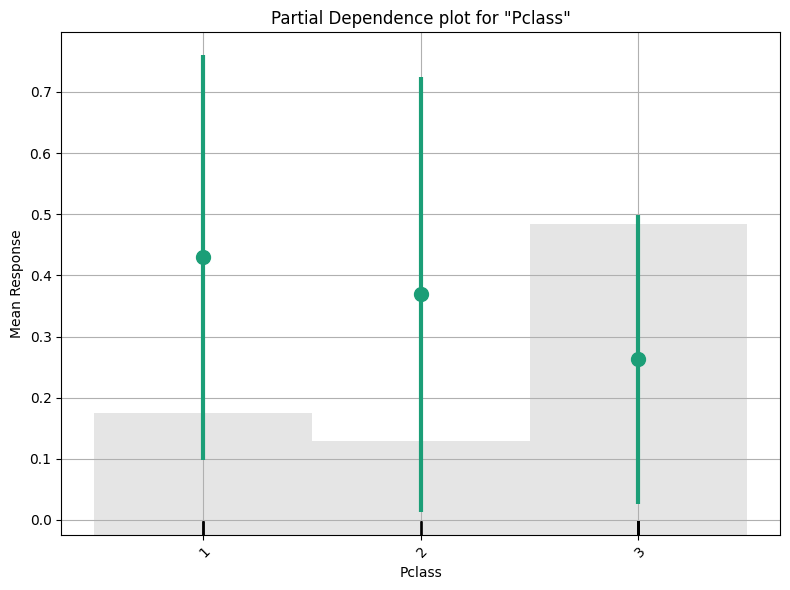

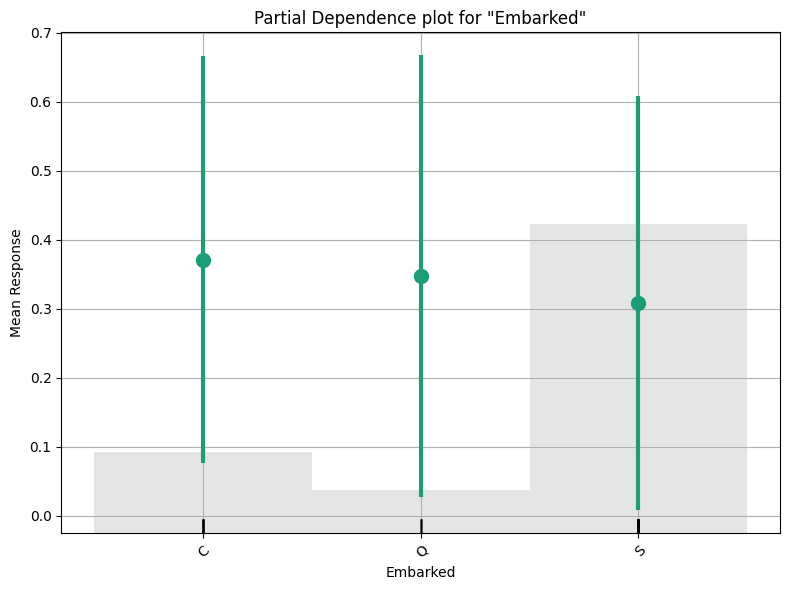

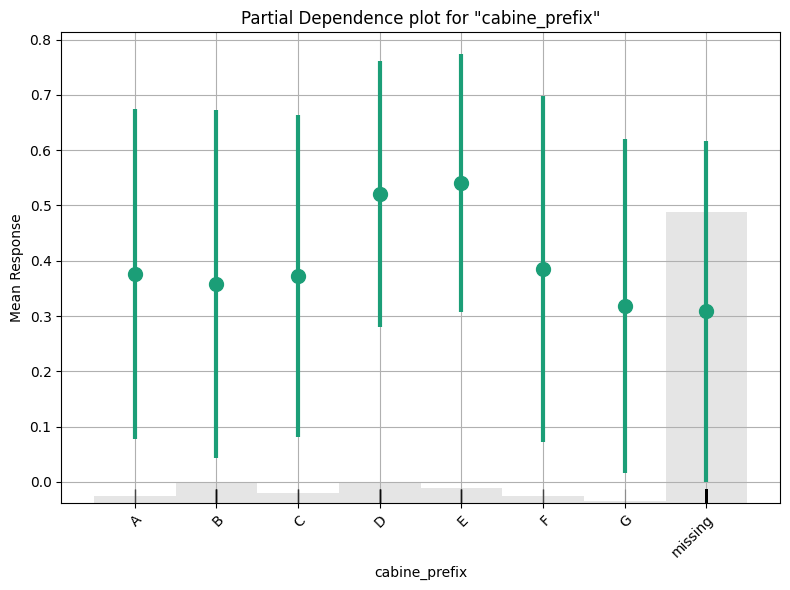

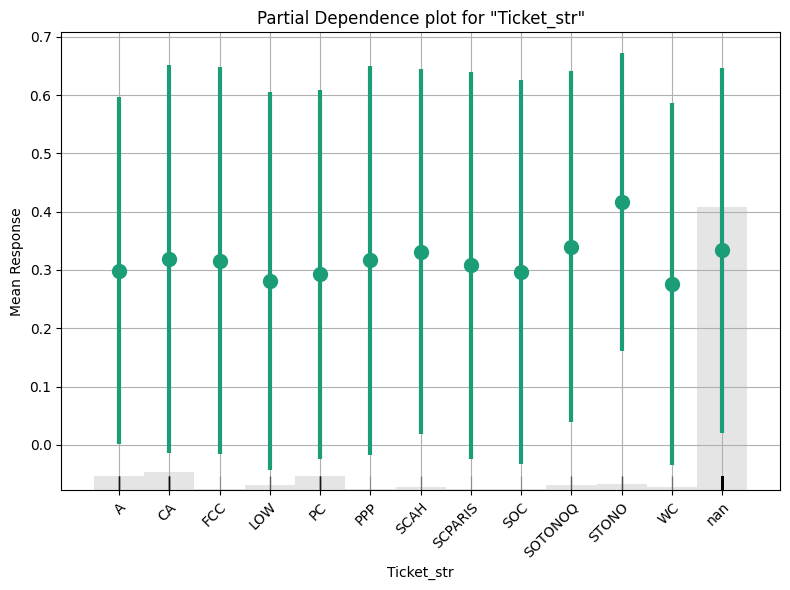

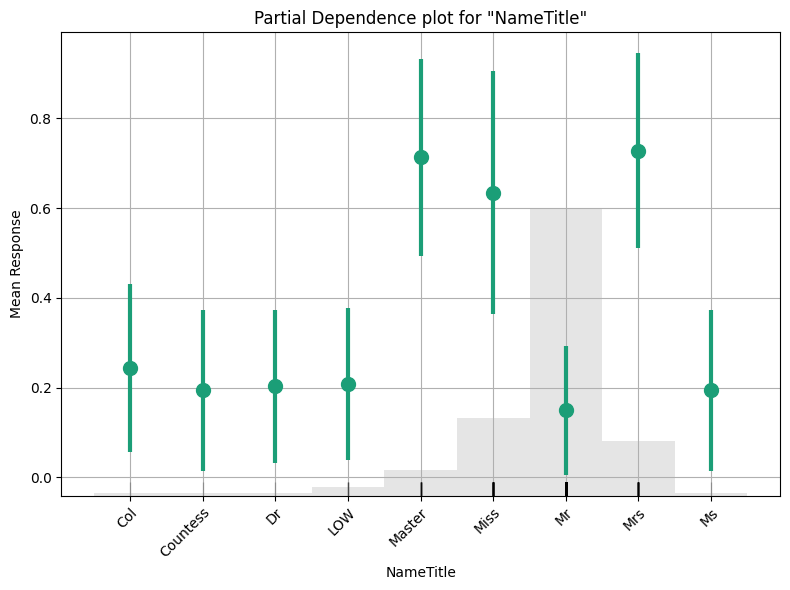

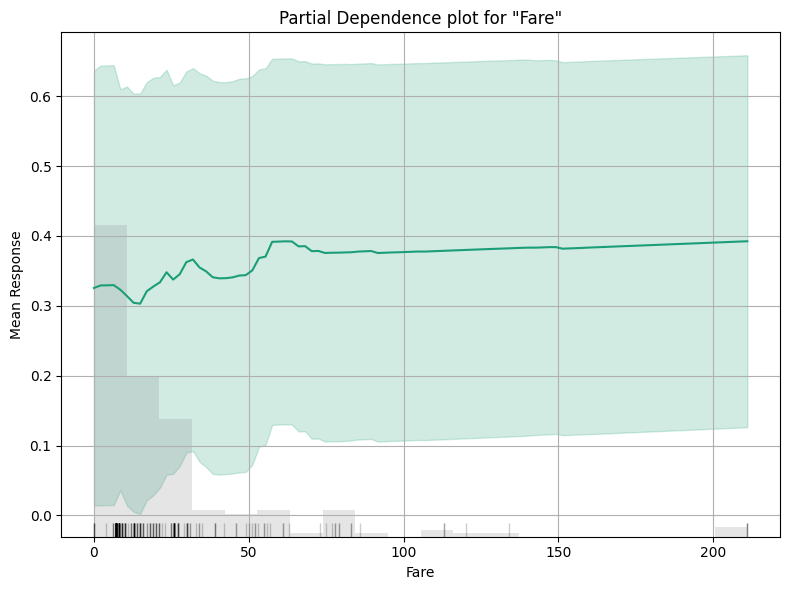

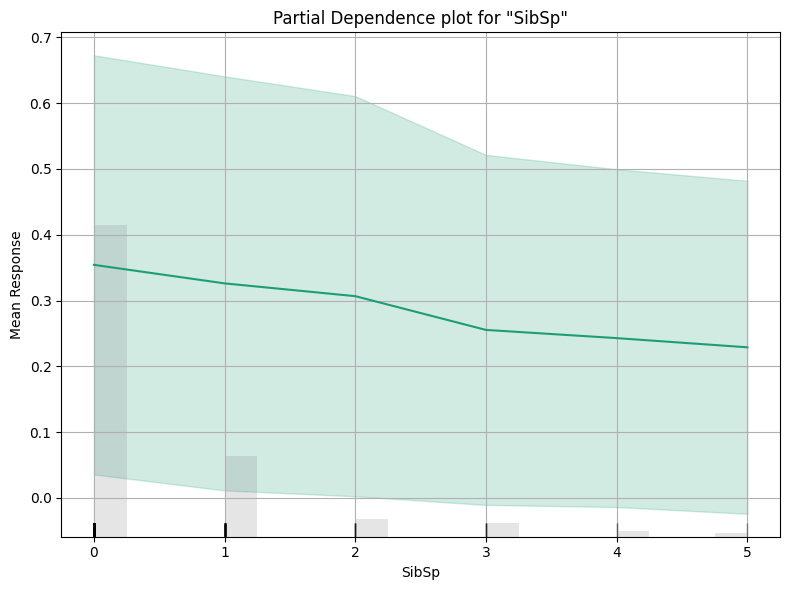

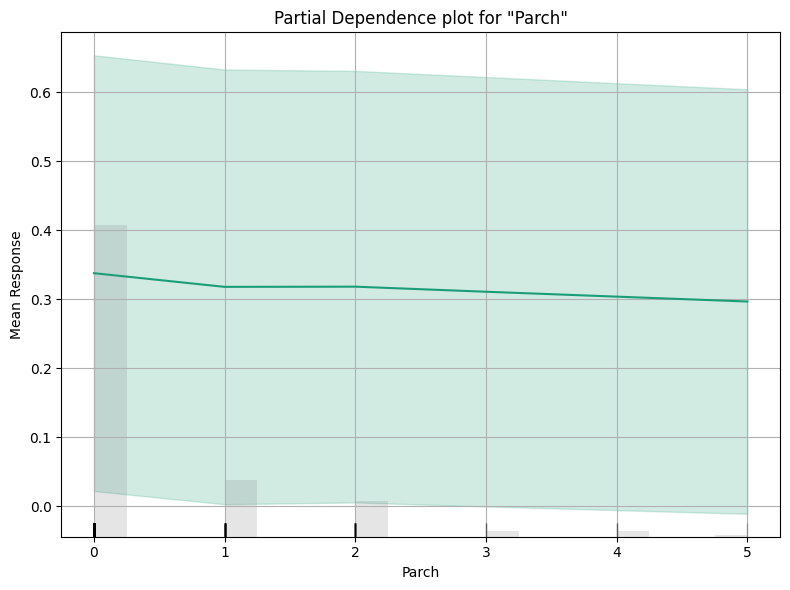

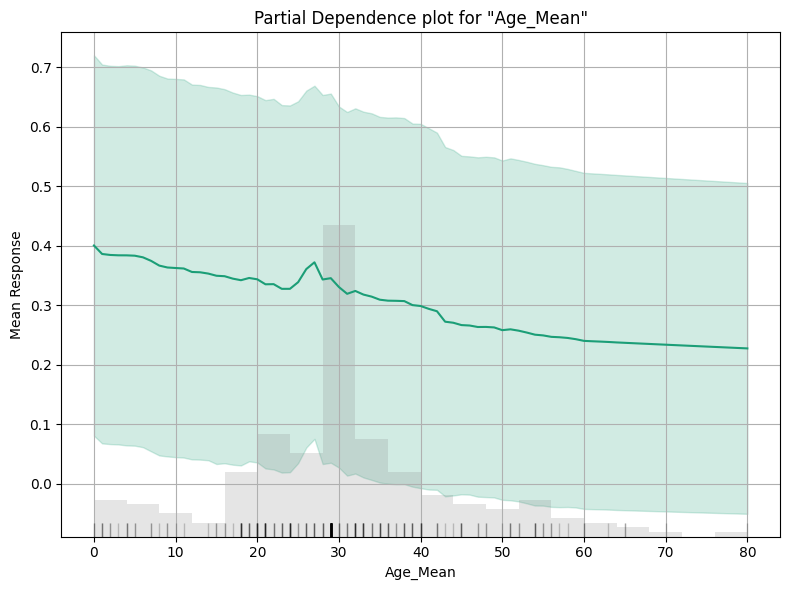

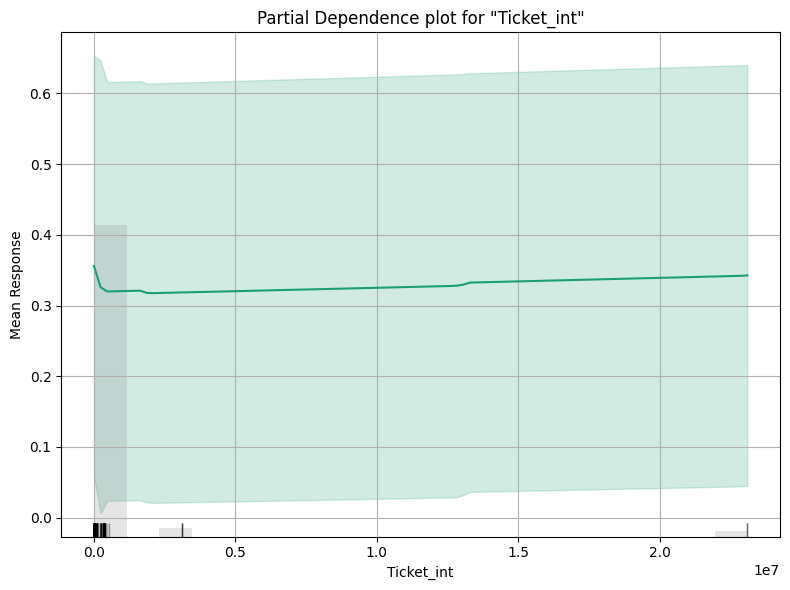

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20221201_193150


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3042507263917874: 


,,0,1,Error,Rate
0,0,119.0,18.0,0.1314,(18.0/137.0)
1,1,19.0,64.0,0.2289,(19.0/83.0)
2,Total,138.0,82.0,0.1682,(37.0/220.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [19]:
best_AutoML.explain(frame=test_hdf, figsize=(8, 6))

## 4.3 Compare performance on the TEST dataset for all trained models

In [20]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [21]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'Ticket_str' has levels not trained on: ["SCAH"]
  warnings.warn(w)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'NameTitle' has levels not trained on: ["Countess", "Ms"]
  warnings.warn(w)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


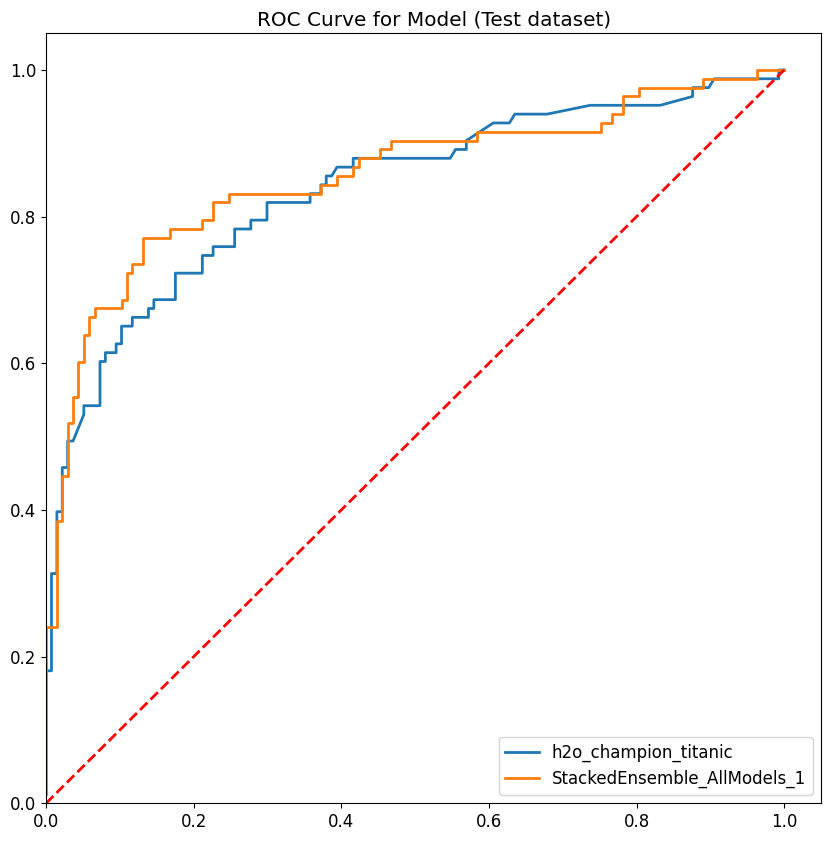

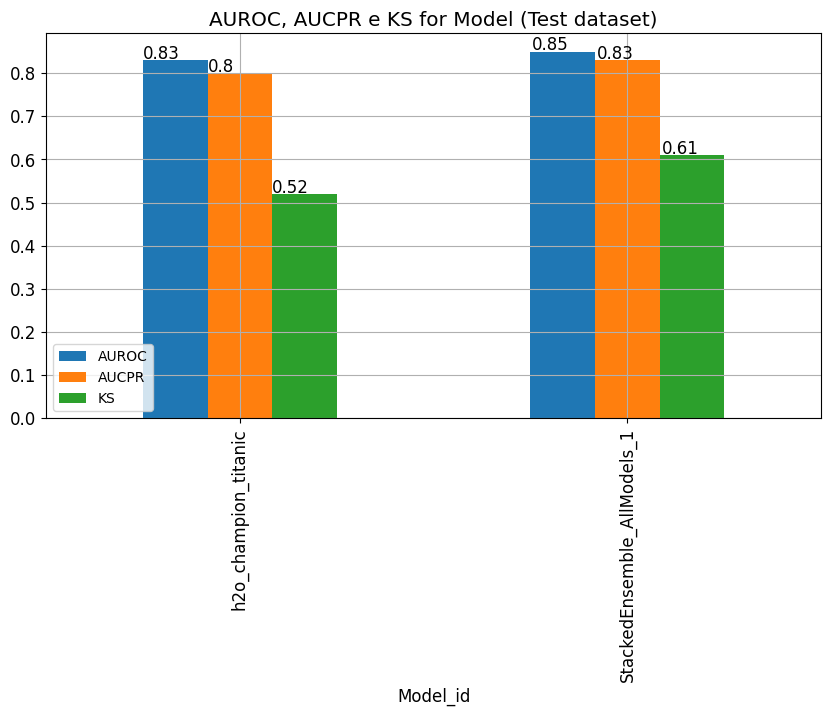

In [22]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('dataset == "test"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [23]:
sort_metric_best_model='AUCPR'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : AUCPR


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,StackedEnsemble_AllModels_1_AutoML_1_20221201_193150,0.473509,0.856037,0.833515,0.436589,0.615,0.304251
1,0,h2o_champion_titanic_propensity_survive_v1_20221201_193127,0.497327,0.838009,0.808254,0.483789,0.524,0.419837



BEST MODEL: h2o_champion_titanic_propensity_survive_v1_20221201_193127



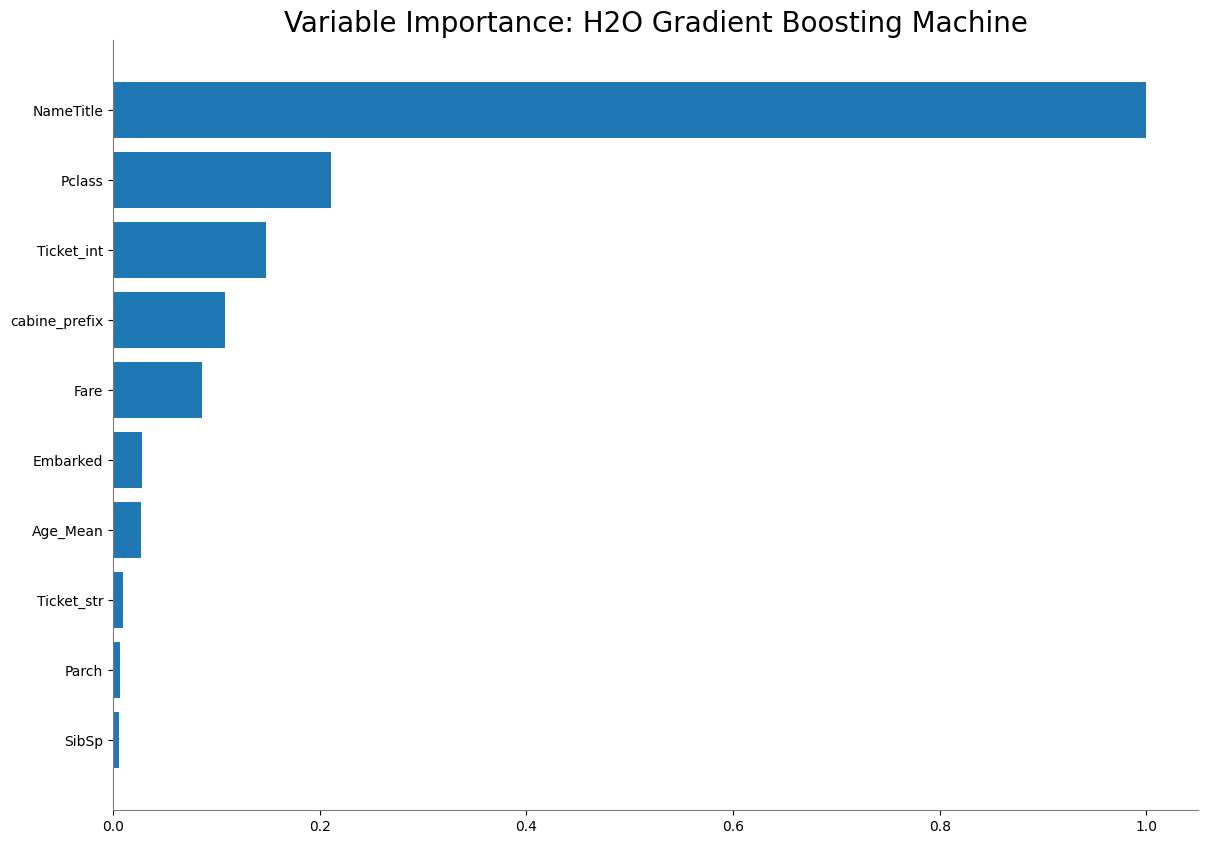

<Figure size 640x480 with 0 Axes>

In [24]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=1

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)    
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    print("Warning: This model doesn't have variable importances")

## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [25]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [26]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'testset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'testset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'testset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'testset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'testset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


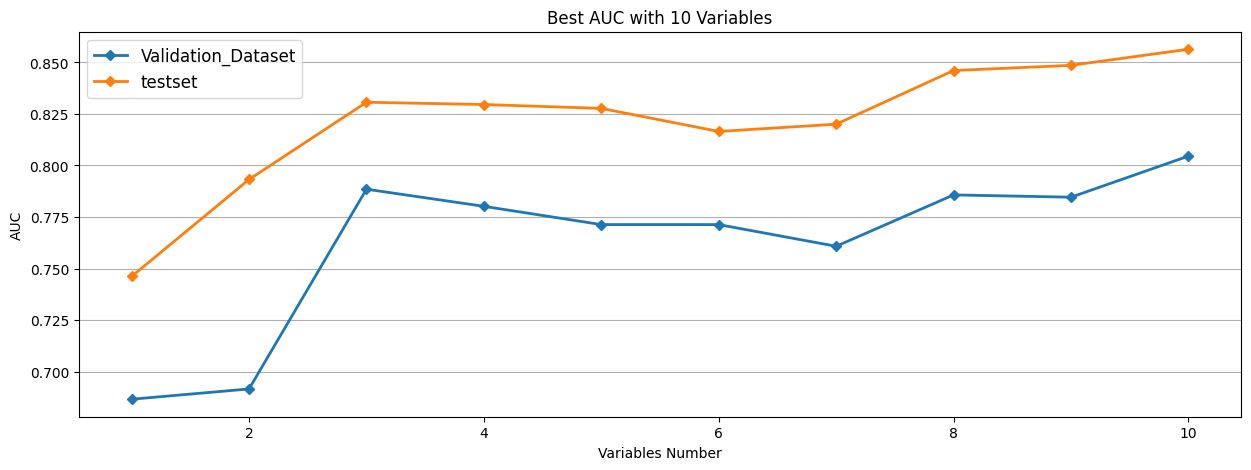

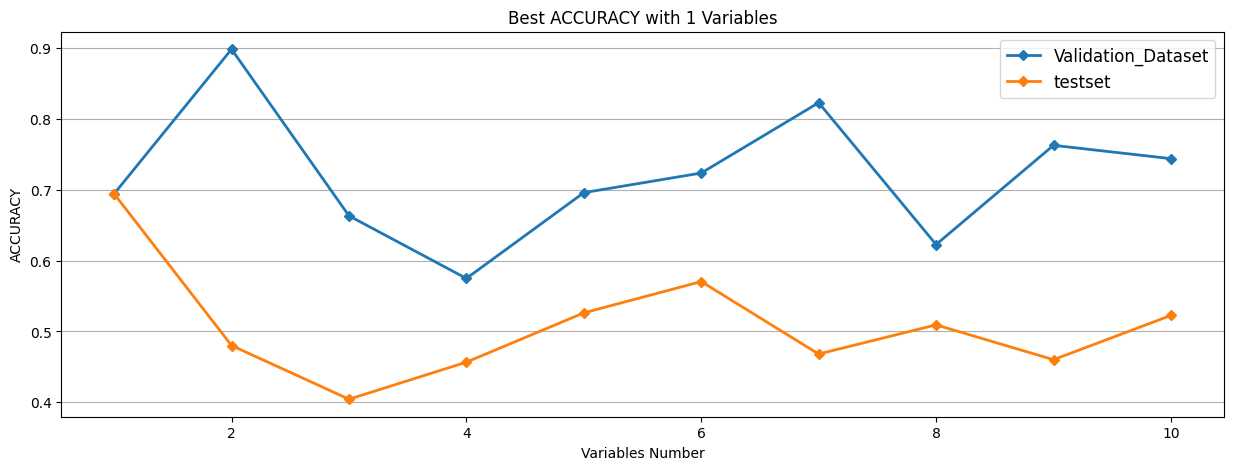

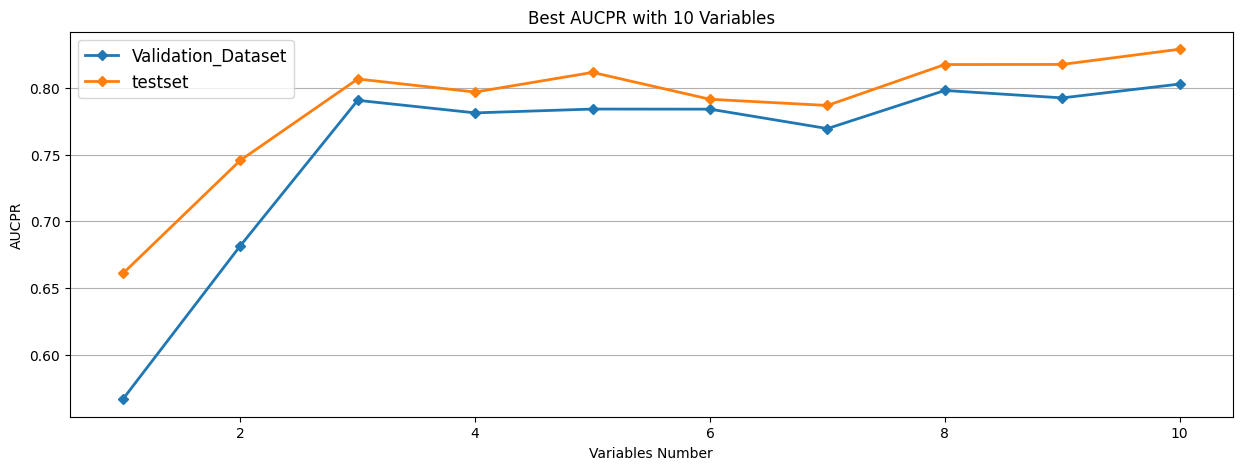

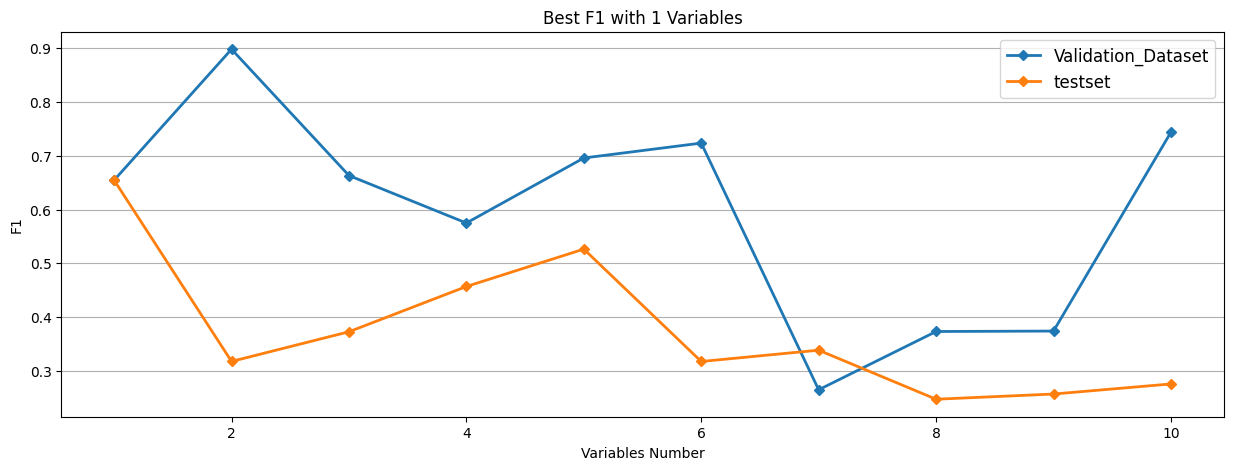

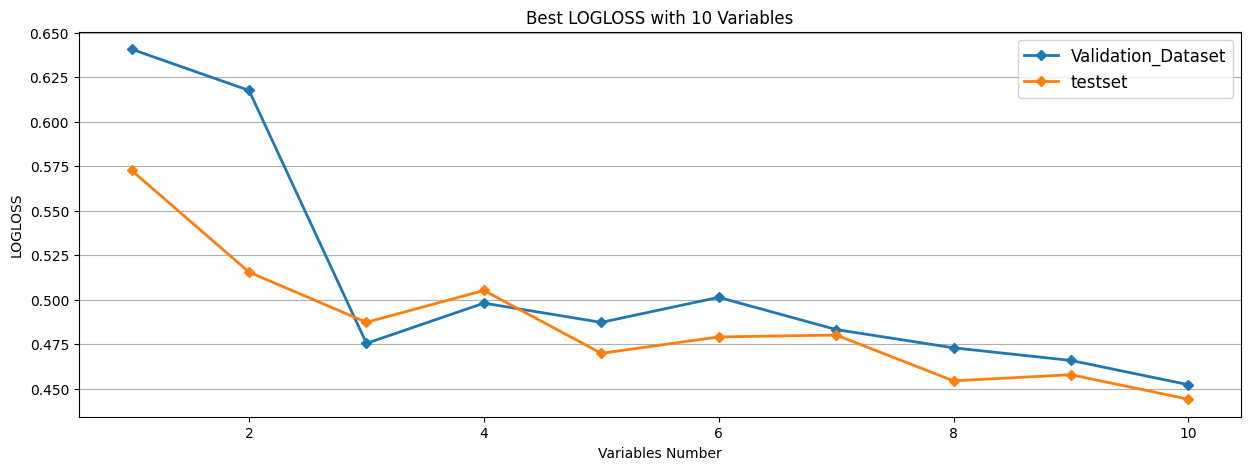

In [27]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['testset'] == metrics_df_tmp.testset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['testset'] == metrics_df_tmp.testset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [28]:
print('Consider using only the following variables: '+ str(df_features_sorted[0:int(max_oot_filtro)]))

Consider using only the following variables: ['NameTitle', 'Pclass', 'Ticket_int', 'cabine_prefix', 'Fare', 'Embarked', 'Age_Mean', 'Ticket_str', 'Parch', 'SibSp']


# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [29]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    print(e)

path_model_mojo: /mnt/batch/tasks/shared/LS_root/mounts/clusters/fiep-cpu/code/Users/maxreis86/FIEP-Machine-Learning-e-Computacao-em-Nuvem/aula_01_titanic_h2o_automl/output_model/models/best/h2o_champion_titanic_propensity_survive_v1_20221201_193127.zip


Detected 1 unused columns in the input data set: {}


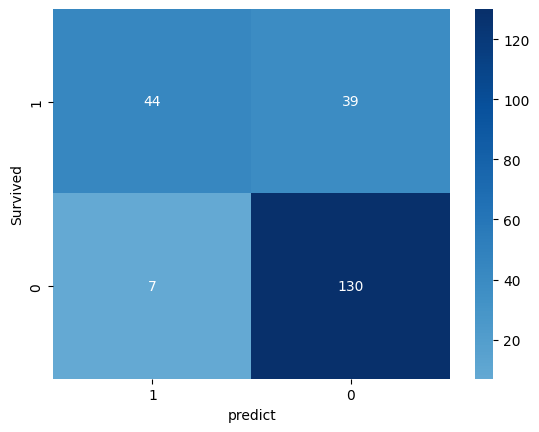

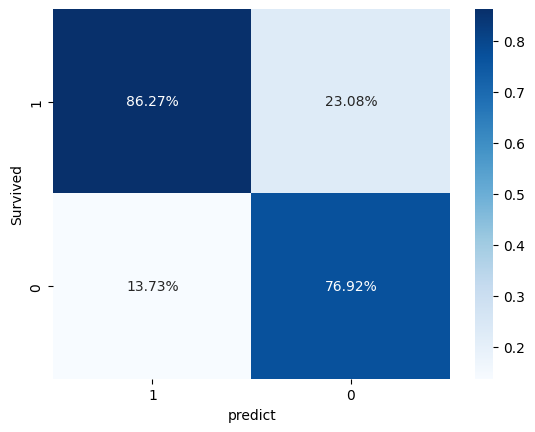

In [30]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 6. Save final dataset with predictions to CSV

In [31]:
df_predict.to_csv('./titanic/df_predict.csv', index=False, header=True)